In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import future.utils
import numpy as np
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op
import networkx as nx
import os
import json
import gzip
from scipy import stats
import seaborn as sns

%matplotlib inline

In [7]:
datapath = os.path.join('..', 'dataset')
datapath

'../dataset'

In [8]:
sns.set_style("white")

In [9]:
g = nx.read_edgelist(f'{datapath}/euro2020_edgelist.csv', delimiter=',', nodetype=str, )

### Number of nodes

In [10]:
g.number_of_nodes()

2925

### Number of edges

In [11]:
g.number_of_edges()

9081

### Metrics

In [12]:
def get_giant_component(graph):
    components = nx.connected_components(graph)
    giant_component = max(components, key=len)
    return graph.subgraph(giant_component)

G = g

num_nodes = len(G.nodes())
num_edges = len(G.edges())
average_degree = sum([degree for (_, degree) in G.degree()]) / num_nodes
average_clustering = nx.average_clustering(G)
try:
    diameter = nx.diameter(G)
except:
    diameter = nx.diameter(get_giant_component(graph=G))

# Print the results
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", average_degree)
print("Average clustering coefficient:", average_clustering)
print("Diameter:", diameter)

Number of nodes: 2925
Number of edges: 9081
Average degree: 6.2092307692307696
Average clustering coefficient: 0.14315099339791218
Diameter: 9


In [13]:
gc = get_giant_component(G)
print(gc.number_of_nodes())
print(gc.number_of_edges())

2894
9054


### Degree distribution

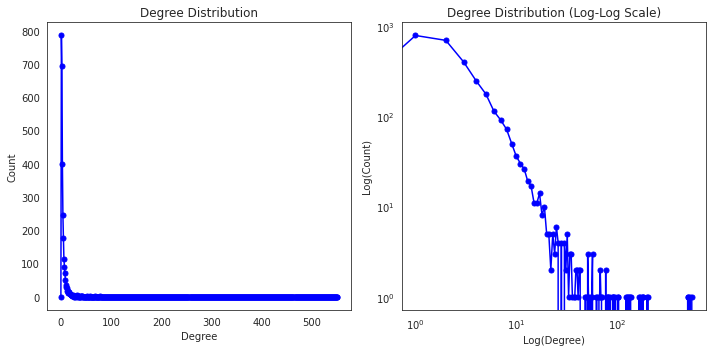

In [10]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = nx.degree_histogram(G)
degrees = range(len(degree_count))

# Plot degree distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(degrees, degree_count, 'b-', marker='o', markersize=5)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')

# Plot degree distribution in log-log scale
plt.subplot(1, 2, 2)
plt.loglog(degrees, degree_count, 'b-', marker='o', markersize=5)
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Count)')
plt.title('Degree Distribution (Log-Log Scale)')

# Show the plots
plt.tight_layout()
plt.show()

In [14]:
!pip install powerlaw

In [15]:
import powerlaw

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
results = powerlaw.Fit(degree_sequence)
is_powerlaw = results.power_law.alpha is not None

# Print the power law fit results
print("Power Law Fit Results:")
print("Power Law Fit:", is_powerlaw)
if is_powerlaw:
    print("Power Law Exponent (alpha):", results.power_law.alpha)
    print("Minimum Degree for Power Law Fit (xmin):", results.power_law.xmin)
    print("Log-Likelihood Ratio Test p-value:", results.power_law.D)
    print("Kolmogorov-Smirnov Test p-value:", results.power_law.KS())

Calculating best minimal value for power law fit
Power Law Fit Results:
Power Law Fit: True
Power Law Exponent (alpha): 2.4689487341556102
Minimum Degree for Power Law Fit (xmin): 5.0
Log-Likelihood Ratio Test p-value: 0.026113635755019182
Kolmogorov-Smirnov Test p-value: 0.026113635755019182


In [16]:
class EchoChamber:
    def __init__(
        self,
        graph: object,
        network_stats: dict = {},
        communities_stats: dict = {},
        labels_stats: dict = {},
        node_stats: dict = {},
        method_name: str = "",
        method_parameters: dict = {},
    ):
        """
        :param graph: a networkx/igraph object
        :param network_stats: dict, optional dictionary containing the measures related to the graph, where for each
                measure name (key) is associated a numerical value (value)
        :param communities_stats: dict, optional dictionary containing the measures related to detected communities
                inside the graph, where for each community integer index (key) is associated a dict (value) specifying for
                each community attribute (key) its value (value)
        :param labels_stats: dict, optional dictionary specifying for each node classification label (key) a
                dict (value) specifying the attribute name (key) related to that label and its value (value) detected by
                the algorithm
        :param node_stats: dictionary containing node related attributes, where for each node (key) there is a
                dictionary (value) specifying for each node attribute name (key) its value (value)
        :param method_name: str, optional the name of the ec detection algorithm used, default to ""
        :param method_parameters: dict, optional dictionary containing the parameter name (key) and its value (value).
                This field refers to the parameters used by the detection algorithm
        """
        self.graph = graph
        self.network_stats = network_stats
        self.communities_stats = communities_stats
        self.labels_stats = labels_stats
        self.node_stats = node_stats
        self.method_name = method_name
        self.method_parameters = method_parameters


In [17]:
!pip install cdlib

In [19]:
import networkx as nx
from cdlib import algorithms
from cdlib.utils import convert_graph_formats

def cinelli(
    g_original: object,
    labels: dict,
    weight: str = "weight",
    resolution: float = 1.0,
    randomize: int = None,
) -> EchoChamber:
    """
    Cinelli et al. use the Louvain Algorithm to find communities, remove singleton communities with only
    one user and then compute each community average leaning (where the leaning is a numerical value used
    to identify the attitude of users at a microlevel), determined as the average of individual
    leanings of its members. They also compute the average leaning of each node neighbourhood.

     Main differences and similarities with the original work:
        - In this implementation we assume that all the nodes share the exact same set of labels

    **Supported Graph Types**

    ========== ======== ======== ======== ==============
    Undirected Directed Weighted Temporal Node Attribute
    ========== ======== ======== ======== ==============
    No        Yes       No       No       Yes
    ========== ======== ======== ======== ==============

    :param g_original: a networkx/igraph object
    :param labels: dictionary specifying for each node (key) a dict (value) specifying the name attribute (key) and its
    value (value)
    :param weight: str, optional the key in graph to use as weight. Default to ‘weight’
    :param resolution: double, optional Will change the size of the communities, default to 1.
    :param randomize: int, RandomState instance or None, optional (default=None).
    If int, random_state is the seed used by the random number generator;
    If RandomState instance, random_state is the random number generator;
    If None, the random number generator is the RandomState instance used by np.random.
    :return: EchoChamber object

    :Example:
    >>> from echo_chambers.detection.micro.cinelli import cinelli
    >>> import networkx as nx
    >>> import random
    >>> values = [0,1,2,3,4,5]
    >>> g = nx.barabasi_albert_graph(100,5)
    >>> labels = dict()
    >>> for node in g.nodes():
    >>>     labels[node] = { "attribute_1": random.choice(values) }
    >>> micro_clusters = cinelli(g, labels)

    :References:

    Cinelli, M., Morales, G. D. F., Galeazzi, A., Quattrociocchi, W., & Starnini, M. (2021). The echo chamber effect on social media. Proceedings of the National Academy of Sciences, 118(9).
    """
    g = convert_graph_formats(g_original, nx.Graph)
    nx.set_node_attributes(g, labels)

    # detecting communities with Louvain Algorithm (cf. Polarization and Homophily in the Interaction Networks)
    clusters = algorithms.louvain(g.to_undirected(), weight, resolution, randomize)
    communities_stats = {
        index: {"community": community}
        for (index, community) in enumerate(clusters.communities)
        if len(community) > 1  # removing singleton communities
    }

    # computing for every node its neighbours' average attribute value
    # (cf. Polarization and Homophily in the Interaction Networks)
    node_labels = dict()
    for node in g.nodes():
        node_labels[node] = {}
        node_neighbours = [_ for _ in g.neighbors(node)]
        number_neighbours = len(node_neighbours)

        for label in labels[node].keys():
            label_score = 0

            if number_neighbours == 0:
                average_label_score = None
            else:
                for neighbour in node_neighbours:
                    label_score += g.nodes[neighbour][label]
                average_label_score = label_score / number_neighbours

            node_labels[node][label] = labels[node][label]
            node_labels[node][f"avg_{label}_neighbours"] = average_label_score

    # computing for every community the average attribute value of its nodes
    # (cf. Polarization and Homophily in the Interaction Networks)
    get_list_average = lambda x: sum(x) / len(x) if len(x) != 0 else None
    for (com_index, community_stats) in communities_stats.items():
        labels_dict = {}
        for node in community_stats["community"]:
            for (label_name, label_value) in labels[node].items():
                if label_name not in labels_dict:
                    labels_dict[label_name] = []
                labels_dict[label_name].append(label_value)
        communities_stats[com_index]["labels_average_score"] = {
            label_name: get_list_average(label_values)
            for (label_name, label_values) in labels_dict.items()
        }

    return EchoChamber(
        graph=g_original,
        communities_stats=communities_stats,
        node_stats=node_labels,
        method_name="Cinelli et al.",
        method_parameters={
            "weight": weight,
            "resolution": resolution,
            "randomize": randomize,
        },
    )


Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer', 'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [20]:
import pandas as pd
def plot_joint_distribution(
    echo_chamber: EchoChamber, label: str, plotname: str, xlim: tuple = (0, 1), ylim: tuple = (0, 1)
) -> object:
    
    """
    Plot the joint distribution of the leaning of users x and the average leaning of their neighborhood. The
    joint distribution is represented as a heatmap. Colors represent the density of users: The lighter the color, the
    larger the number of users.
    Marginal distribution P(x) and P^{N}(x) are plotted on the x and y axes. (cfr. Fig 1 of the original work)
    :param echo_chamber: EchoChamber object containing the detected communities
    :param label: str, the name of the attribute in node_labels to use for the x-axis
    :param xlim: tuple of numbers, optional specifies the x axis limit
    :param ylim: tuple of numbers, optional specifies the y axis limit
    :return: a JointGrid instance
    Example:
    >>> import networkx as nx
    >>> import random
    >>> from echo_chambers.detection.micro.cinelli import cinelli
    >>> from echo_chambers import viz
    >>>
    >>> g = nx.karate_club_graph()
    >>> scores = {}
    >>> score_attribute_name = "score"
    >>> scores = {
    ...     node: {
    ...             score_attribute_name: random.random()
    ...     }
    ...     for node in g.nodes()
    ... }
    >>> detected_echo_chambers = cinelli(g, scores)
    >>> viz.plot_joint_distribution(detected_echo_chambers, score_attribute_name)
    """
    y_label = f"avg_opinion_neighbours"
    data = (
        [stats[label], stats[y_label]] for _, stats in echo_chamber.node_stats.items()
    )
    df = pd.DataFrame(data=data, columns=[label, y_label])
    x, y = df[label], df[y_label]
    g = sns.JointGrid(dropna=True, xlim=xlim, ylim=ylim)
    # main plot
    sns.kdeplot(
        x=x,
        y=y,
        cut=12,
        fill=True,
        thresh=0,
        n_levels=50,
        ax=g.ax_joint,
        cmap="inferno",
    )
    # plot on x-axis
    sns.histplot(x=x, stat="probability", color="lightgrey", ax=g.ax_marg_x)
    # plot on y-axis
    sns.histplot(y=y, stat="probability", color="lightgrey", ax=g.ax_marg_y)

    plt.tight_layout()

    if plotname is not None:
        plt.savefig(plotname, bbox_inches="tight", facecolor="white")
    else:
        plt.show()
    plt.close()


In [21]:
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [22]:
def plot_polarization(filename):
    plotname = filename.strip('.json')
    # Load data from file
    with open(f'res/{filename}', 'r') as f:
        try:
            nodelist = json.load(f)
            nodelist = nodelist["0"]
            nodes = {}
            for k, v in nodelist.items():
                try:
                    nodes[int(k)] = float(v)
                except KeyError:
                    continue
                except ValueError:
                    nodes[int(k)] = float(v)
        except Exception as e:
            print(f'Error loading data from {filename}: {str(e)}')
            return

    # Extract 'label' values from the dictionary
    labels = {k: {'opinion':v} for k, v in nodes.items()}
    echo_chamber = cinelli(g, labels)
    try:
        plot_joint_distribution(echo_chamber, 'opinion', plotname)
    except ValueError as e:  
        print(f'could not make plot {plotname}')
        print(e)
        return 

In [23]:
def plot_label_distribution(nodes, plotname=None):
    # Extract 'label' values from the dictionary
    labels = [entry for entry in nodes.values()]
    # Plotting the distribution
    sns.histplot(labels, edgecolor='black', binwidth=0.1)
    plt.xlabel('Opinion')
    plt.ylabel('Frequency')
    plt.title('Distribution of Opinions')
    plt.xlim(0, 1)
    plt.ylim(0, 3000)
    plt.savefig(f'plots/{plotname}', bbox_inches='tight', facecolor='white')
    plt.close()

In [25]:
with open(f'{datapath}/euro2020_t0.json', 'r') as f:
    nodelist = json.load(f)
    initialdata = {}
    for k, v in nodelist.items():
        try:
            initialdata[int(k)] = float(v)
        except KeyError:
            # print(f'Node {k} not present in graph')
            continue
initialdata
# initialdata = list(initialdata.values())
with open(f'{datapath}/euro2020_t1.json', 'r') as f:
    nodelist = json.load(f)
    finaldata = {}
    for k, v in nodelist.items():
        try:
            finaldata[int(k)] = float(v)
        except KeyError:
            # print(f'Node {k} not present in graph')
            continue
finaldata

{451: 0.9444444444444443,
 2368: 0.6666666666666666,
 2480: 0.3333333333333333,
 2814: 1.0,
 2582: 0.3333333333333333,
 791: 0.4166666666666667,
 573: 0.3333333333333333,
 2925: 1.0,
 350: 0.861111111111111,
 224: 0.5,
 1778: 0.3333333333333333,
 1671: 0.3333333333333333,
 2926: 0.6666666666666666,
 2758: 0.5,
 2443: 0.6666666666666666,
 1444: 0.0,
 2927: 1.0,
 2630: 0.3333333333333333,
 759: 0.7777777777777778,
 2643: 0.3333333333333333,
 831: 0.6666666666666666,
 716: 1.0,
 2928: 0.3333333333333333,
 1873: 1.0,
 478: 0.9166666666666666,
 1251: 0.5,
 1051: 0.8333333333333334,
 134: 1.0,
 2735: 0.6666666666666666,
 2811: 0.3333333333333333,
 188: 0.6666666666666666,
 316: 0.5,
 306: 1.0,
 1034: 1.0,
 2725: 0.3333333333333333,
 2822: 1.0,
 2929: 0.5,
 1728: 0.3333333333333333,
 1477: 0.3333333333333333,
 366: 0.6666666666666666,
 1018: 0.5,
 1886: 0.3055555555555555,
 427: 0.7777777777777778,
 1941: 0.5444444444444444,
 1321: 0.3333333333333333,
 428: 0.5524691358024691,
 2930: 0.0,
 48

In [26]:
np.mean(np.array([v for v in initialdata.values() if v >= 0.6]))

0.8655269900413921

In [27]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=3000)
    return cmp

spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']
spaghetti_cmap=get_continuous_cmap(spaghetti_hex_list)

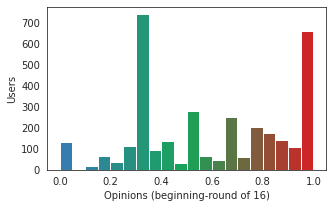

In [28]:
import matplotlib.cm as cm
from matplotlib import colors

fig = plt.figure(figsize=(5, 3))

opinions = list(initialdata.values())

# Set up the histogram plot using seaborn
n, bins, patches = plt.hist(opinions, 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', spaghetti_cmap(c))

plt.xlabel('Opinions (beginning-round of 16)')
plt.ylabel('Users')

# Display the histogram
plt.show()

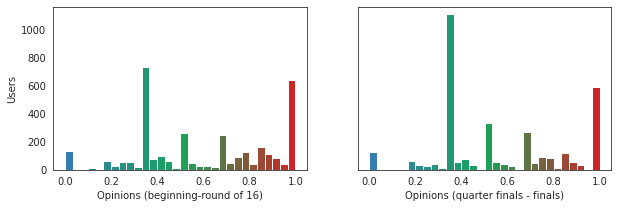

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharey=True)

opinions = list(initialdata.values())

# Set up the histogram plot using seaborn
n, bins, patches = axes[0].hist(opinions, 30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', spaghetti_cmap(c))

axes[0].set_xlabel('Opinions (beginning-round of 16)')
axes[0].set_ylabel('Users')



opinions = list(finaldata.values())

# Set up the histogram plot using seaborn
n, bins, patches = axes[1].hist(opinions, 30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', spaghetti_cmap(c))

axes[1].set_xlabel('Opinions (quarter finals - finals)')

# Display the histogram
plt.show()

In [30]:
id = np.array(list(initialdata.values()))
id1 = id[id <= 0.4]
len(id1)

1194

In [31]:
id = np.array(list(initialdata.values()))
id2 = id[id >= 0.6]
len(id2)

1643

In [32]:
id = np.array(list(initialdata.values()))
len(id)-len(id1)-len(id2)

511

In [33]:
id = np.array(list(finaldata.values()))
id1 = id[id <= 0.4]
len(id1)

1467

In [34]:
id = np.array(list(finaldata.values()))
id2 = id[id >= 0.6]
len(id2)

1343

In [35]:
id = np.array(list(finaldata.values()))
len(id)-len(id1)-len(id2)

538

In [36]:
len(finaldata) == len(initialdata)

True

In [43]:
g = nx.relabel_nodes(g, {n:int(n) for n in g.nodes}, copy=True)

In [44]:
g.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

{0: 8, 1: 6, 2: 77, 3: 16, 4: 3, 5: 2, 6: 25, 7: 17, 8: 8, 9: 35, 10: 501, 11: 32, 12: 25, 13: 509, 14: 2, 15: 31, 16: 6, 17: 5, 18: 19, 19: 6, 20: 8, 21: 41, 22: 15, 23: 12, 24: 9, 25: 92, 26: 28, 27: 529, 28: 31, 29: 12, 30: 69, 31: 103, 32: 4, 33: 8, 34: 13, 35: 6, 36: 5, 37: 10, 38: 11, 39: 165, 40: 13, 41: 7, 42: 15, 43: 5, 44: 4, 45: 20, 46: 14, 47: 1, 48: 4, 49: 13, 50: 11, 51: 6, 52: 9, 53: 4, 54: 3, 55: 5, 56: 8, 57: 1, 58: 2, 59: 4, 60: 15, 61: 14, 62: 7, 63: 1, 64: 2, 65: 6, 66: 4, 67: 8, 68: 1, 69: 3, 70: 4, 71: 11, 72: 11, 73: 2, 74: 10, 75: 6, 76: 6, 77: 7, 78: 5, 79: 7, 80: 7, 81: 1, 82: 4, 83: 9, 84: 7, 85: 1, 86: 6, 87: 3, 88: 9, 89: 2, 90: 1, 91: 5, 92: 5, 93: 4, 94: 5, 95: 6, 96: 5, 97: 6, 98: 10, 99: 2, 100: 4, 101: 2, 102: 3, 103: 3, 104: 7, 105: 5, 106: 3, 107: 4, 108: 1, 109: 2, 110: 19, 111: 35, 112: 2, 113: 3, 114: 4, 115: 1, 116: 8, 117: 3, 118: 5, 119: 2, 120: 10, 121: 1, 122: 6, 123: 4, 124: 9, 125: 5, 126: 175, 127: 21, 128: 6, 129: 9, 130: 70, 131: 20, 132

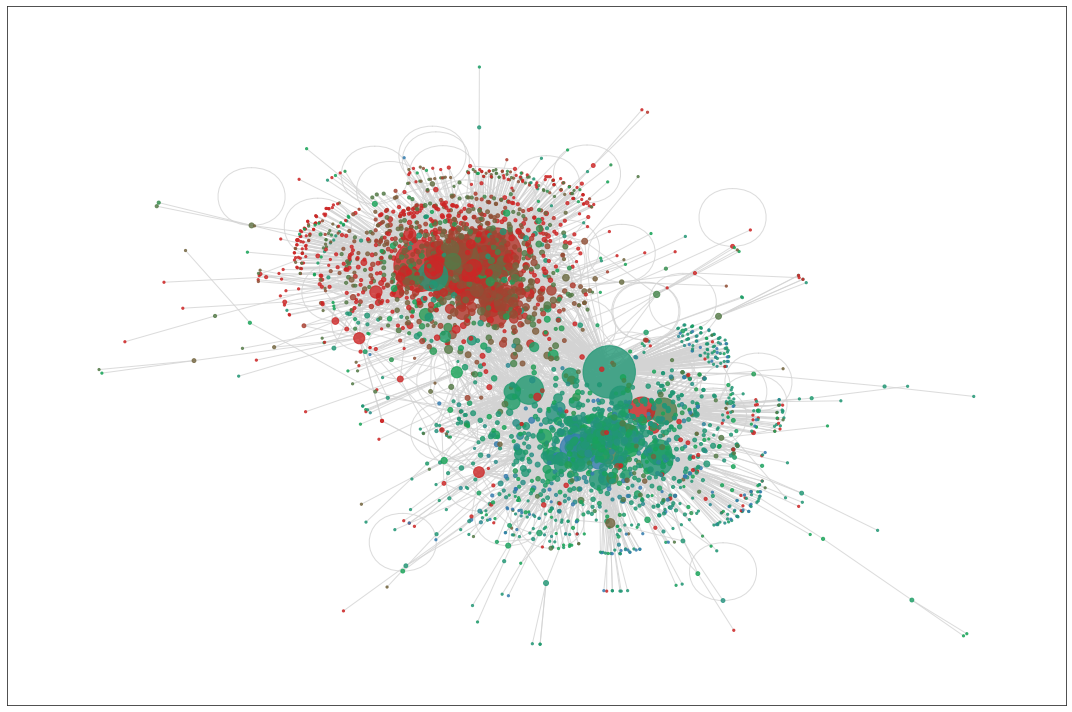

In [45]:
def get_giant_component(graph):
    components = nx.connected_components(graph)
    giant_component = max(components, key=len)
    return graph.subgraph(giant_component)

G = get_giant_component(graph=g)
d = dict(G.degree)
print(d)
# Prepare a list of colors based on attribute values
colors = [spaghetti_cmap(initialdata[node]) for node in G.nodes()]
# Set the edge color to grey
edge_color = "lightgrey"
# Set the figure size
plt.figure(figsize=(15, 10))
# Plot the graph
pos = nx.spring_layout(G, seed=0)  # You can use different layout algorithms
nx.draw_networkx(G, pos=pos, node_color=colors, alpha=0.8, node_size=[v*5 for v in d.values()], edge_color=edge_color, with_labels=False)
plt.tight_layout()
# Show the plot
# plt.savefig('network_t0.png', bbox_inches='tight', facecolor="white")
plt.show()
plt.close()

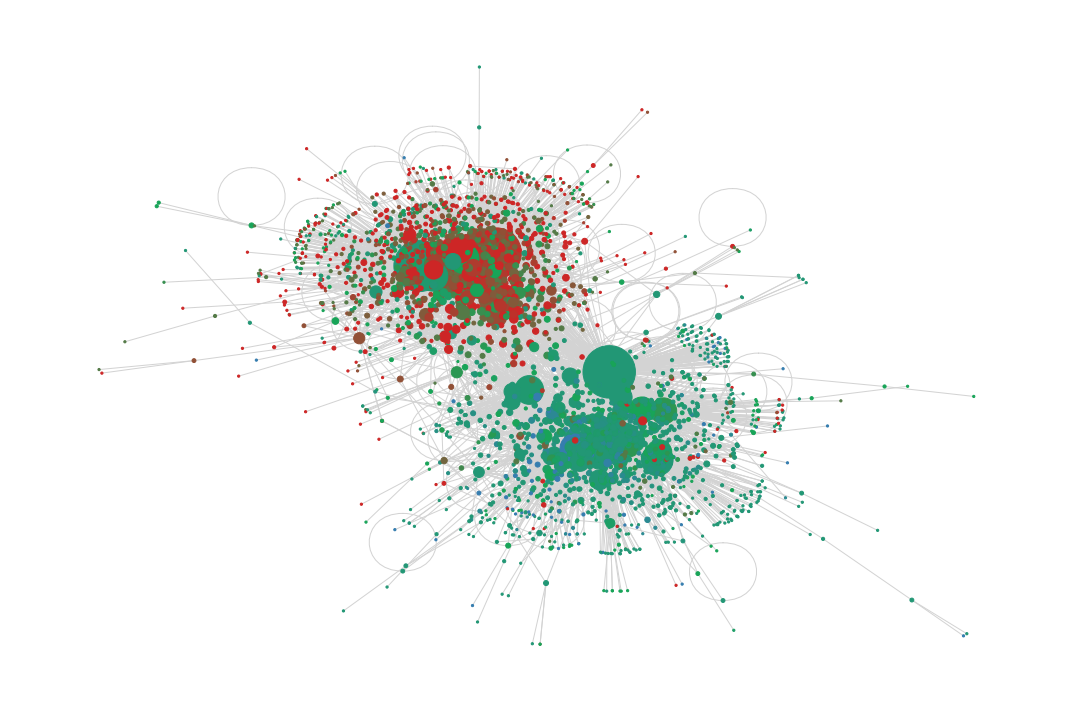

In [46]:
def get_giant_component(graph):
    components = nx.connected_components(graph)
    giant_component = max(components, key=len)
    return graph.subgraph(giant_component)

G = get_giant_component(graph=g)
# Prepare a list of colors based on attribute values
colors = [spaghetti_cmap(finaldata[node]) for node in G.nodes()]
# Set the edge color to grey
edge_color = "lightgrey"
# Set the figure size
plt.figure(figsize=(15, 10), facecolor="white")
axes = plt.axes()
axes.set_facecolor("white")
# Plot the graph
pos = nx.spring_layout(G, seed=0)  # You can use different layout algorithms
nx.draw_networkx(G, pos=pos, node_color=colors, node_size=[v*5 for v in d.values()], edge_color=edge_color, with_labels=False)
plt.tight_layout()
plt.axis("off")
# Show the plot
# plt.savefig('network_t1.png', bbox_inches='tight', facecolor="white")
plt.show()
plt.close()

In [47]:
graph = g

In [48]:
labels = {k: {'opinion':v} for k, v in initialdata.items()}
echo_chamber = cinelli(graph, labels)
plot_joint_distribution(echo_chamber, 'opinion', 't0_polarization.png')

In [49]:
labels = {k: {'opinion':v} for k, v in finaldata.items()}
echo_chamber = cinelli(graph, labels)
plot_joint_distribution(echo_chamber, 'opinion', 't1_polarization.png')

In [50]:
!pip install node_conformity

(array([1.230e+02, 2.000e+00, 3.000e+00, 8.000e+00, 1.000e+00, 6.100e+01,
        3.100e+01, 2.500e+01, 4.000e+01, 1.300e+01, 1.104e+03, 5.600e+01,
        7.500e+01, 3.600e+01, 3.000e+00, 3.340e+02, 5.200e+01, 3.800e+01,
        2.700e+01, 9.000e+00, 2.670e+02, 4.800e+01, 9.200e+01, 8.100e+01,
        1.300e+01, 1.160e+02, 5.300e+01, 3.600e+01, 9.000e+00, 5.920e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

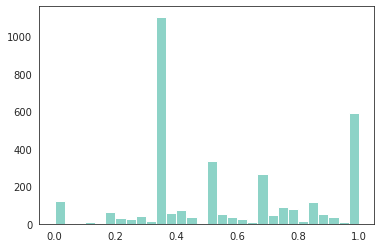

In [51]:
plt.hist(finaldata.values(), bins=30)

In [52]:
from conformity import attribute_conformity
datadiscr_final = {}
for k, v in finaldata.items():
    if v <= 0.4:
        datadiscr_final[k] = 'pro'
    elif v >= 0.6:
        datadiscr_final[k] = 'against'
    else:
        datadiscr_final[k] = 'neutral'

nx.set_node_attributes(G, datadiscr_final, name='opinion')
node_to_conformity_final = attribute_conformity(G, list(np.arange(0, 4, 0.5)), ['opinion'], profile_size=1)

from conformity import attribute_conformity
datadiscr_initial = {}
for k, v in finaldata.items():
    if v <= 0.4:
        datadiscr_initial[k] = 'pro'
    elif v >= 0.6:
        datadiscr_initial[k] = 'against'
    else:
        datadiscr_initial[k] = 'neutral'

nx.set_node_attributes(G, datadiscr_initial, name='opinion')
node_to_conformity_initial = attribute_conformity(G, list(np.arange(0, 4, 0.5)), ['opinion'], profile_size=1)

100%|██████████| 2894/2894 [02:02<00:00, 23.69it/s]


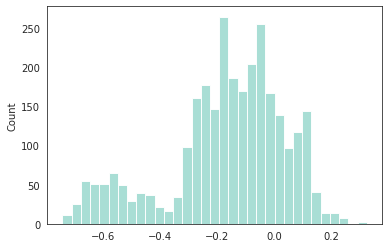

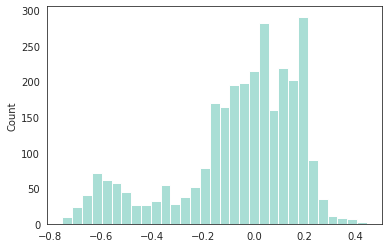

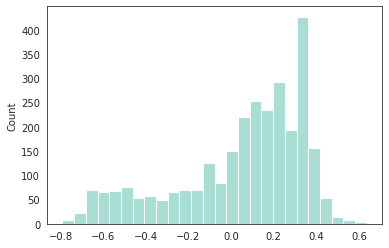

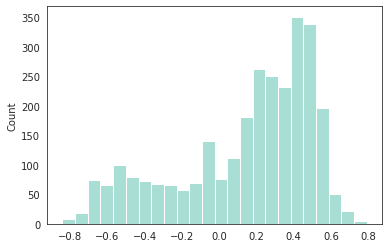

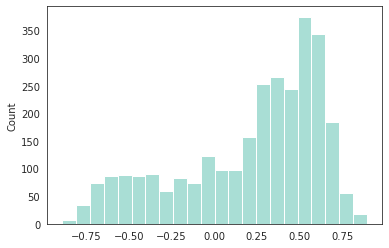

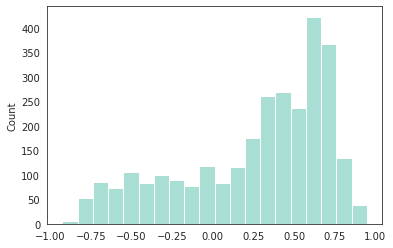

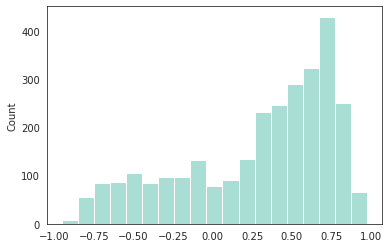

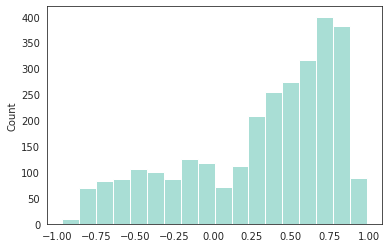

In [53]:
for k in node_to_conformity_initial.keys():
    values_final = node_to_conformity_initial[k]['opinion']
    sns.histplot(values_final)
    plt.show()
    plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

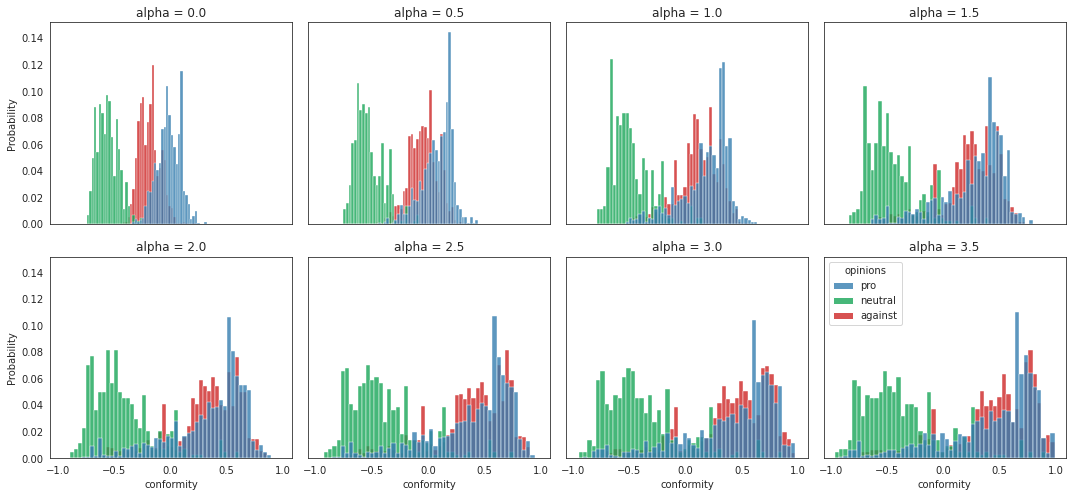

In [54]:
palette = {
    'pro': '#357db0',
    'neutral': '#18A558',
    'against': '#ce2626'
}

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.flatten()
i = 0
for k in node_to_conformity_initial.keys():
    values = node_to_conformity_initial[k]['opinion']
    df = pd.DataFrame({'conformity':pd.Series(dict(sorted(values.items()))),'opinions':pd.Series(dict(sorted(datadiscr_initial.items())))})
    g = sns.histplot(data=df, x = 'conformity', hue='opinions', palette = palette, multiple='layer', hue_order = ['pro', 'neutral', 'against'], alpha = 0.8, bins=50, common_norm = False, stat='probability', ax = axes[i])
    g.set_title(f'alpha = {k}')
    if i != 7:
        g.legend().remove()
    plt.tight_layout()
    i+=1

  0%|          | 0/100 [00:00<?, ?it/s]

e0.3_g1.5_media_2media.json
Correlation: 0.9420832063846021


  2%|▏         | 2/100 [00:02<02:15,  1.38s/it]

e0.3_g1.0_media_3media.json
Correlation: 0.7366794988039567


  3%|▎         | 3/100 [00:05<02:56,  1.82s/it]

could not make plot e0.3_g1.0_media_3media.json
e0.3_g1.5_media_avg_pros.json
Correlation: 0.8502224117476755


  5%|▌         | 5/100 [00:07<02:18,  1.45s/it]

could not make plot e0.3_g1.5_media_avg_pros.json
e0.3_g1.0_media_avg_cons.json
Correlation: 0.8041563664665803


  7%|▋         | 7/100 [00:09<02:07,  1.37s/it]

could not make plot e0.3_g1.0_media_avg_cons.json
e0.2_g1.5_nomedia.json
Correlation: 0.9744134695494568


  8%|▊         | 8/100 [00:12<02:35,  1.69s/it]

e0.2_g0.0_media_avg_pros.json
Correlation: 0.8196059458653957


  9%|▉         | 9/100 [00:15<03:01,  2.00s/it]

e0.2_g1.0_media_2media.json
Correlation: 0.7856811304873961


 10%|█         | 10/100 [00:18<03:11,  2.13s/it]

e0.4_g1.5_media_avg_pros.json
Correlation: 0.7727544791793052


 11%|█         | 11/100 [00:21<03:29,  2.36s/it]

e0.2_g1.5_media_avg_cons.json
Correlation: 0.8266657276145848


 12%|█▏        | 12/100 [00:24<03:45,  2.56s/it]

e0.3_g0.5_media_avg_neut.json
Correlation: 0.8924155863909251


 14%|█▍        | 14/100 [00:27<02:58,  2.08s/it]

e0.2_g0.0_media_avg_cons.json
Correlation: 0.8475843455622236


 15%|█▌        | 15/100 [00:30<03:13,  2.28s/it]

e0.2_g0.0_media_3media.json
Correlation: 0.7220959561081924


 16%|█▌        | 16/100 [00:32<03:16,  2.34s/it]

e0.3_g0.5_media_2media.json
Correlation: 0.7343478541219489


 17%|█▋        | 17/100 [00:34<03:16,  2.36s/it]

e0.3_g0.0_media_avg_cons.json
Correlation: 0.8800008307981373


 20%|██        | 20/100 [00:38<02:11,  1.64s/it]

e0.2_g0.0_media_2media.json
Correlation: 0.7327830841152456


 22%|██▏       | 22/100 [00:40<01:58,  1.52s/it]

e0.2_g0.5_media_2media.json
Correlation: 0.7635117273223941


 25%|██▌       | 25/100 [00:43<01:34,  1.26s/it]

e0.3_g0.0_media_2media.json
Correlation: 0.7503311935330557


 27%|██▋       | 27/100 [00:45<01:30,  1.25s/it]

e0.3_g1.0_media_avg_neut.json
Correlation: 0.8590138773435089


 30%|███       | 30/100 [00:48<01:19,  1.14s/it]

e0.3_g1.5_media_3media.json
Correlation: 0.889860728899316


 31%|███       | 31/100 [00:55<02:14,  1.95s/it]

e0.3_g1.5_nomedia.json
Correlation: 0.9735985469611654


 32%|███▏      | 32/100 [00:57<02:21,  2.08s/it]

e0.2_g1.0_nomedia.json
Correlation: 0.9916439262446116


 35%|███▌      | 35/100 [01:00<01:38,  1.52s/it]

could not make plot e0.2_g1.0_nomedia.json
e0.4_g0.0_media_avg_neut.json
Correlation: 0.9101193692499758


 36%|███▌      | 36/100 [01:03<01:52,  1.76s/it]

e0.4_g1.0_media_avg_neut.json
Correlation: 0.8526022557010343


 37%|███▋      | 37/100 [01:05<02:05,  1.99s/it]

e0.4_g1.0_nomedia.json
Correlation: 0.9955303363810222


 38%|███▊      | 38/100 [01:08<02:06,  2.05s/it]

could not make plot e0.4_g1.0_nomedia.json
e0.2_g0.5_nomedia.json
Correlation: 0.999999940818759


 39%|███▉      | 39/100 [01:10<02:07,  2.09s/it]

could not make plot e0.2_g0.5_nomedia.json
e0.3_g1.0_nomedia.json
Correlation: 0.9968384638553682


 40%|████      | 40/100 [01:12<02:07,  2.12s/it]

could not make plot e0.3_g1.0_nomedia.json
e0.4_g0.5_media_2media.json
Correlation: 0.7316166694244888


 41%|████      | 41/100 [01:15<02:10,  2.21s/it]

e0.2_g0.5_media_3media.json
Correlation: 0.7493779442304292


 42%|████▏     | 42/100 [01:17<02:18,  2.39s/it]

e0.4_g0.0_media_2media.json
Correlation: 0.7416214469823748


 44%|████▍     | 44/100 [01:20<01:45,  1.89s/it]

e0.2_g1.0_media_avg_pros.json
Correlation: 0.7406287600709415


 45%|████▌     | 45/100 [01:23<01:57,  2.14s/it]

e0.2_g0.0_media_avg_neut.json
Correlation: 0.9176215532141125


 49%|████▉     | 49/100 [01:26<01:09,  1.36s/it]

e0.2_g1.5_media_avg_pros.json
Correlation: 0.7720980005565351


 50%|█████     | 50/100 [01:29<01:21,  1.63s/it]

e0.4_g1.0_media_2media.json
Correlation: 0.8147331620819124


 51%|█████     | 51/100 [01:31<01:28,  1.80s/it]

e0.2_g1.5_media_avg_neut.json
Correlation: 0.8057854945711297


 53%|█████▎    | 53/100 [01:34<01:13,  1.57s/it]

could not make plot e0.2_g1.5_media_avg_neut.json
e0.3_g1.5_media_avg_cons.json
Correlation: 0.7351888044148684


 55%|█████▌    | 55/100 [01:36<01:05,  1.45s/it]

could not make plot e0.3_g1.5_media_avg_cons.json
e0.3_g1.5_media_avg_neut.json
Correlation: 0.8113231826367965


 56%|█████▌    | 56/100 [01:39<01:16,  1.74s/it]

e0.2_g0.5_media_avg_pros.json
Correlation: 0.813145583474804


 57%|█████▋    | 57/100 [01:42<01:25,  1.99s/it]

e0.4_g0.5_nomedia.json
Correlation: 0.9999995233696433


 58%|█████▊    | 58/100 [01:44<01:25,  2.04s/it]

could not make plot e0.4_g0.5_nomedia.json
e0.4_g0.0_nomedia.json
Correlation: 0.9999933295546233


 59%|█████▉    | 59/100 [01:46<01:25,  2.09s/it]

could not make plot e0.4_g0.0_nomedia.json
e0.2_g1.0_media_avg_cons.json
Correlation: 0.8209953560217772


 60%|██████    | 60/100 [01:50<01:34,  2.37s/it]

e0.3_g0.0_media_avg_pros.json
Correlation: 0.8479283153446752


 61%|██████    | 61/100 [01:52<01:36,  2.47s/it]

e0.2_g1.0_media_3media.json
Correlation: 0.8121920293292034


 63%|██████▎   | 63/100 [01:55<01:13,  1.99s/it]

could not make plot e0.2_g1.0_media_3media.json
e0.4_g0.0_media_avg_pros.json
Correlation: 0.8216343797940944


 64%|██████▍   | 64/100 [01:58<01:17,  2.17s/it]

e0.3_g0.5_media_avg_pros.json
Correlation: 0.8801931234846613


 65%|██████▌   | 65/100 [02:00<01:16,  2.20s/it]

could not make plot e0.3_g0.5_media_avg_pros.json
e0.2_g0.5_media_avg_cons.json
Correlation: 0.847697832968501


 66%|██████▌   | 66/100 [02:03<01:21,  2.39s/it]

e0.4_g0.5_media_avg_neut.json
Correlation: 0.8487290230795997


 67%|██████▋   | 67/100 [02:05<01:18,  2.37s/it]

could not make plot e0.4_g0.5_media_avg_neut.json
e0.2_g0.0_nomedia.json
Correlation: 0.9999923658034781


 68%|██████▊   | 68/100 [02:08<01:14,  2.33s/it]

could not make plot e0.2_g0.0_nomedia.json
e0.4_g1.5_media_2media.json
Correlation: 0.9311632674807502


 70%|███████   | 70/100 [02:10<00:57,  1.91s/it]

e0.4_g1.0_media_3media.json
Correlation: 0.757079664953337


 71%|███████   | 71/100 [02:13<00:59,  2.04s/it]

could not make plot e0.4_g1.0_media_3media.json
e0.2_g1.0_media_avg_neut.json
Correlation: 0.8193564695990793


 72%|███████▏  | 72/100 [02:16<01:04,  2.30s/it]

e0.3_g0.5_media_3media.json
Correlation: 0.7311924385755767


 73%|███████▎  | 73/100 [02:19<01:06,  2.44s/it]

e0.2_g1.5_media_3media.json
Correlation: 0.8887171920090601


 74%|███████▍  | 74/100 [02:21<01:05,  2.51s/it]

e0.4_g1.0_media_avg_pros.json
Correlation: 0.7941741537141201


 76%|███████▌  | 76/100 [02:24<00:46,  1.93s/it]

could not make plot e0.4_g1.0_media_avg_pros.json
e0.3_g1.0_media_avg_pros.json
Correlation: 0.7547866530103315


 77%|███████▋  | 77/100 [02:27<00:50,  2.19s/it]

e0.2_g1.5_media_2media.json
Correlation: 0.9377766269860761


 78%|███████▊  | 78/100 [02:30<00:53,  2.45s/it]

e0.4_g1.0_media_avg_cons.json
Correlation: 0.8391343644925896


 79%|███████▉  | 79/100 [02:33<00:53,  2.57s/it]

e0.4_g1.5_media_avg_cons.json
Correlation: 0.8080816145836686


 82%|████████▏ | 82/100 [02:36<00:30,  1.72s/it]

e0.4_g1.5_media_3media.json
Correlation: 0.8963849163545894


 83%|████████▎ | 83/100 [02:39<00:32,  1.94s/it]

e0.4_g0.0_media_3media.json
Correlation: 0.7484996032795939


 85%|████████▌ | 85/100 [02:41<00:25,  1.72s/it]

e0.4_g0.5_media_3media.json
Correlation: 0.7162573408031166


 86%|████████▌ | 86/100 [02:44<00:27,  1.94s/it]

e0.3_g0.0_nomedia.json
Correlation: 0.9999918842066111


 87%|████████▋ | 87/100 [02:46<00:26,  2.01s/it]

could not make plot e0.3_g0.0_nomedia.json
e0.4_g1.5_nomedia.json
Correlation: 0.9704288205352225


 88%|████████▊ | 88/100 [02:49<00:26,  2.18s/it]

e0.4_g0.0_media_avg_cons.json
Correlation: 0.8929520965891802


 89%|████████▉ | 89/100 [02:51<00:24,  2.20s/it]

could not make plot e0.4_g0.0_media_avg_cons.json
e0.3_g1.0_media_2media.json
Correlation: 0.7856656269192256


 90%|█████████ | 90/100 [02:54<00:22,  2.28s/it]

e0.3_g0.5_nomedia.json
Correlation: 0.9999999086350568


 91%|█████████ | 91/100 [02:56<00:20,  2.27s/it]

could not make plot e0.3_g0.5_nomedia.json
e0.2_g0.5_media_avg_neut.json
Correlation: 0.8888247952564345


 92%|█████████▏| 92/100 [02:59<00:19,  2.44s/it]

e0.4_g1.5_media_avg_neut.json
Correlation: 0.8349042548129946


 93%|█████████▎| 93/100 [03:02<00:18,  2.64s/it]

e0.3_g0.0_media_avg_neut.json
Correlation: 0.9134319159647938


 94%|█████████▍| 94/100 [03:05<00:16,  2.67s/it]

e0.3_g0.0_media_3media.json
Correlation: 0.7224868489105243


 96%|█████████▌| 96/100 [03:08<00:08,  2.14s/it]

e0.3_g0.5_media_avg_cons.json
Correlation: 0.8772884172316783


 98%|█████████▊| 98/100 [03:11<00:03,  1.89s/it]

e0.4_g0.5_media_avg_pros.json
Correlation: 0.8343324155144974


 99%|█████████▉| 99/100 [03:14<00:02,  2.12s/it]

e0.4_g0.5_media_avg_cons.json
Correlation: 0.8751265554014408


100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


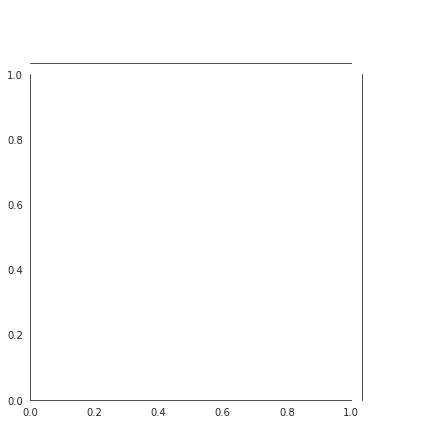

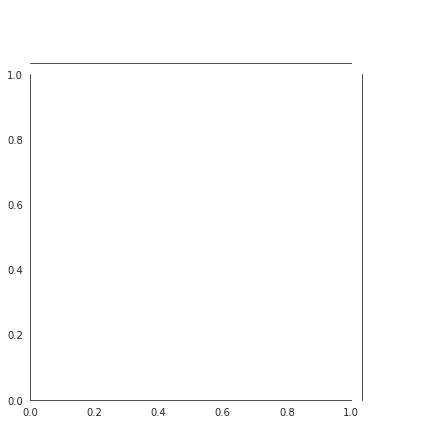

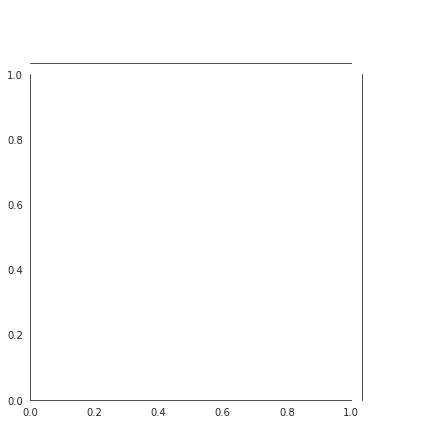

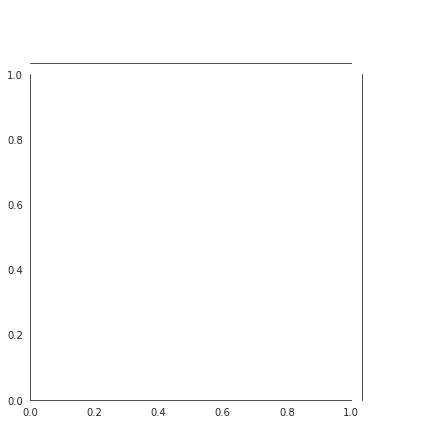

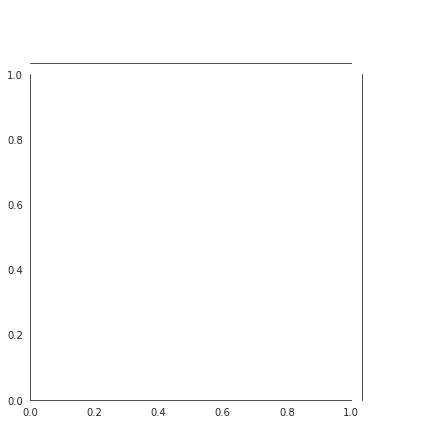

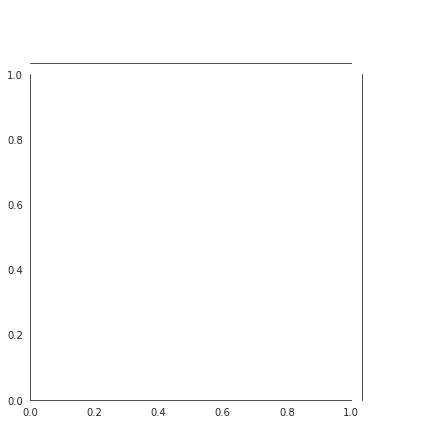

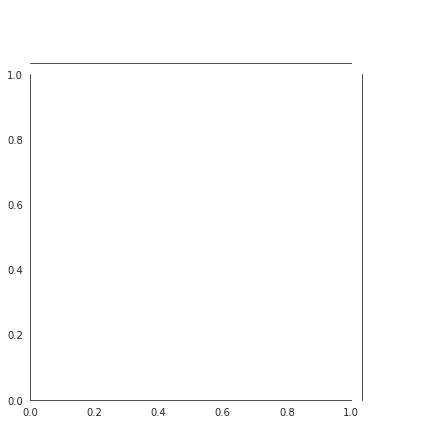

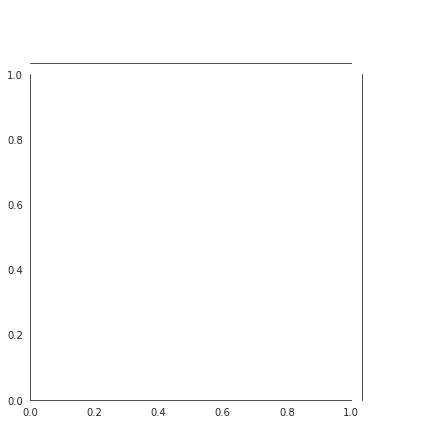

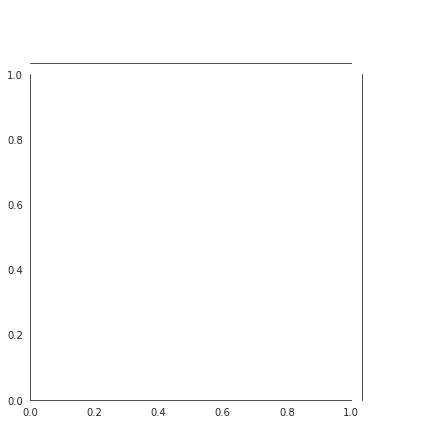

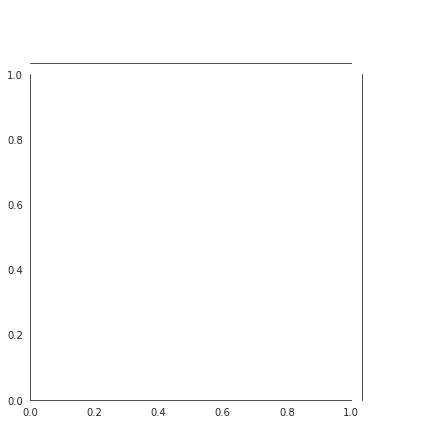

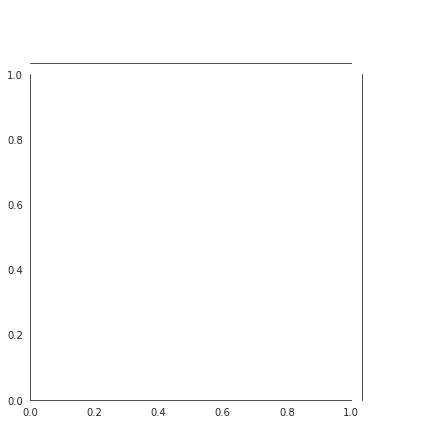

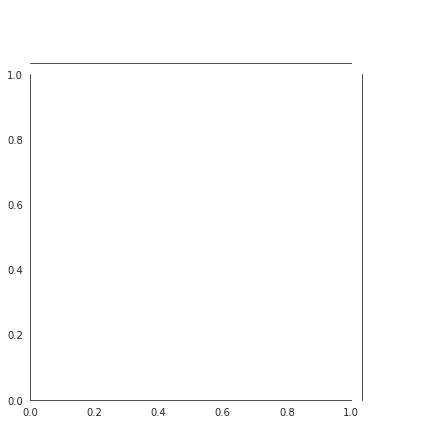

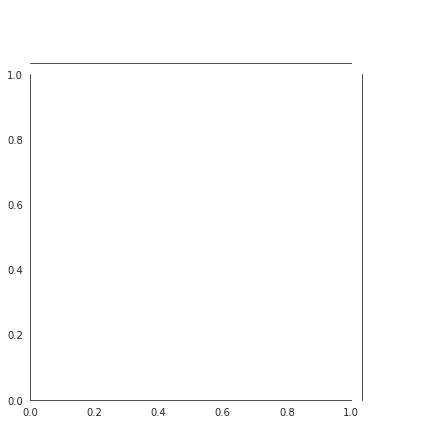

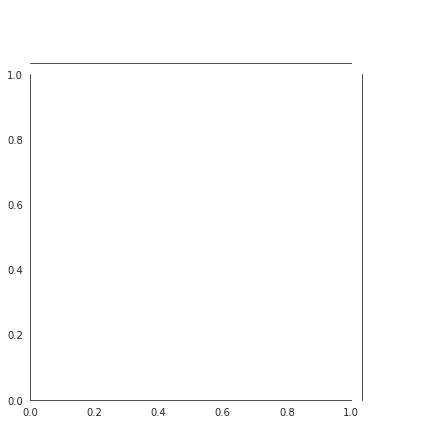

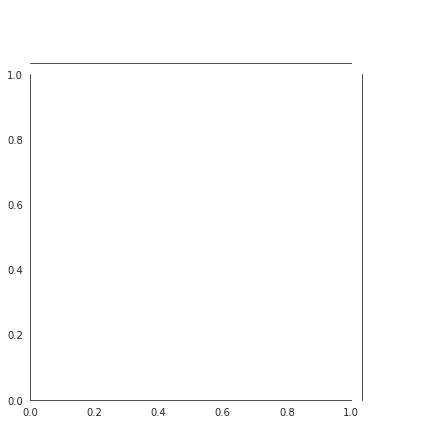

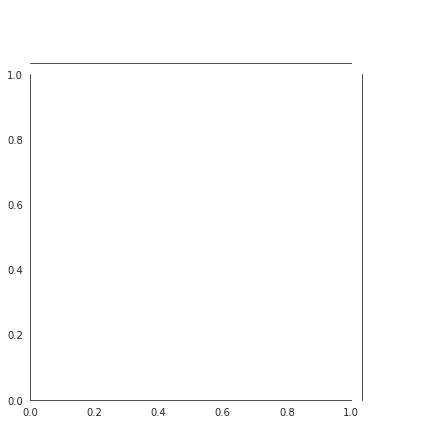

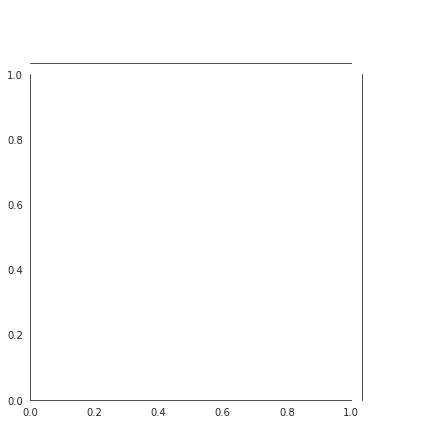

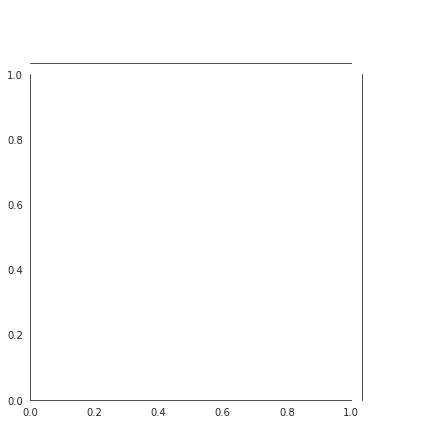

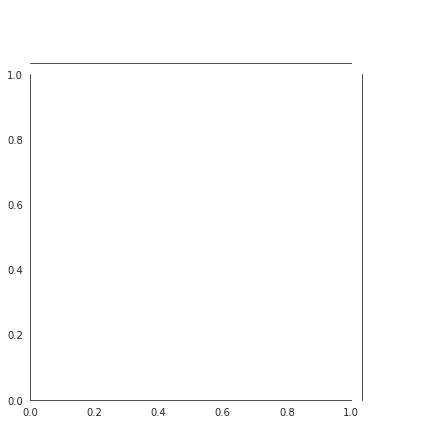

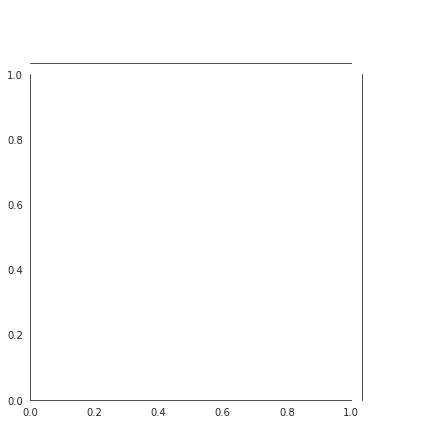

In [16]:
import tqdm

def compute_ego_average(graph, node, attribute):
    ego_network = nx.ego_graph(graph, node)
    attributes = nx.get_node_attributes(ego_network, attribute)
    return sum(attributes.values()) / len(attributes)

sns.set_style("white")
for filename in tqdm.tqdm(os.listdir('res/')):
    if filename.startswith('e0.') and filename.endswith('.json'):
        print(filename)
        with open(f'res/{filename}', 'r') as f:
            nodelist = json.load(f)
            for run in ['0']:
                try:
                    nodelist = nodelist[run]
                except KeyError:
                    pass
                simulationdata = {}
                for k, v in nodelist.items():
                    try:
                        simulationdata[int(mapping[k])] = float(v)
                    except KeyError:
                        try:
                            simulationdata[int(k)] = float(v)
                        except ValueError:
                            print(f'Node {k} not present in graph')
                            continue
                nx.set_node_attributes(graph, {n:o for n,o in simulationdata.items()}, "opinion")
                node_attributes = nx.get_node_attributes(graph, 'opinion')
                df = pd.DataFrame(node_attributes.items(), columns=['node', 'opinion'])
                df['ego_average'] = df['node'].apply(lambda x: compute_ego_average(graph, x, 'opinion'))
                correlation = df['opinion'].corr(df['ego_average'])
                print("Correlation:", correlation)
                labels = {k: {'opinion':v} for k, v in simulationdata.items()}
                echo_chamber = cinelli(graph, labels)
                try:
                    plotname = f'plots/{filename.replace(".json", "_polarization.png")}'
                    plot_joint_distribution(echo_chamber, 'opinion', plotname)
                except ValueError as e:
                    print(f'could not make plot {filename}')
                    continue

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tqdm

def get_giant_component(graph):
    components = nx.connected_components(graph)
    giant_component = max(components, key=len)
    return graph.subgraph(giant_component)

for filename in tqdm.tqdm(os.listdir('res/')):
    if filename.startswith('e0.') and filename.endswith('json'):
        print(filename)
        with open(f'res/{filename}', 'r') as f:
            nodelist = json.load(f)
            try:
                nodelist = nodelist["0"]
            except KeyError:
                pass
            simulationdata = {}
            for k, v in nodelist.items():
                try:
                    simulationdata[int(mapping[k])] = float(v)
                except KeyError:
                    try:
                        simulationdata[int(k)] = float(v)
                    except ValueError:
                        print(f'Node {k} not present in graph')
                        continue
        # Create a random graph with 3000 nodes
        G = get_giant_component(graph=graph)

        d = dict(G.degree)
        
        # Generate attribute values for nodes (assuming a dictionary with {node_id: attribute_value})
        # attribute_values = {node: attribute_value for node, attribute_value in simulationdata.items()}

        # Prepare a list of colors based on attribute values
        colors = [spaghetti_cmap(simulationdata[node]) for node in G.nodes()]

        # Set the edge color to grey
        edge_color = "lightgrey"

        # Set the figure size
        plt.figure(figsize=(15, 10))

        # Plot the graph
        pos = nx.spring_layout(G, seed=0)  # You can use different layout algorithms
        
        nx.draw_networkx(G, pos=pos, node_color=colors, node_size=[v*5 for v in d.values()], edge_color=edge_color, with_labels=False)
        plt.tight_layout()
        plt.axis("off")
        plotname = f'plots/networks_{filename.replace(".json", ".png")}'

        # Show the plot
        plt.savefig(plotname, bbox_inches='tight', facecolor="white")
        plt.close()

  0%|          | 0/78 [00:00<?, ?it/s]

e0.3_g1.5_media_avg_pros.json


  4%|▍         | 3/78 [00:25<10:32,  8.43s/it]

e0.3_g1.0_media_avg_cons.json


  6%|▋         | 5/78 [00:50<12:37, 10.37s/it]

e0.2_g1.5_nomedia.json


  8%|▊         | 6/78 [01:15<16:59, 14.16s/it]

e0.2_g0.0_media_avg_pros.json


  9%|▉         | 7/78 [01:39<20:09, 17.03s/it]

e0.4_g1.5_media_avg_pros.json


 10%|█         | 8/78 [02:04<22:24, 19.20s/it]

e0.2_g1.5_media_avg_cons.json


 12%|█▏        | 9/78 [02:29<23:57, 20.83s/it]

e0.3_g0.5_media_avg_neut.json


 14%|█▍        | 11/78 [02:55<19:13, 17.22s/it]

e0.2_g0.0_media_avg_cons.json


 15%|█▌        | 12/78 [03:20<21:11, 19.27s/it]

e0.3_g0.0_media_avg_cons.json


 19%|█▉        | 15/78 [03:46<14:30, 13.82s/it]

e0.2_g0.0_media_2media.json


 22%|██▏       | 17/78 [04:12<13:42, 13.49s/it]

e0.2_g0.5_media_2media.json


 26%|██▌       | 20/78 [04:37<11:03, 11.43s/it]

e0.3_g1.0_media_avg_neut.json


 31%|███       | 24/78 [05:03<08:17,  9.21s/it]

e0.3_g1.5_nomedia.json


 32%|███▏      | 25/78 [05:28<10:04, 11.41s/it]

e0.2_g1.0_nomedia.json


 36%|███▌      | 28/78 [05:54<08:35, 10.32s/it]

e0.4_g0.0_media_avg_neut.json


 37%|███▋      | 29/78 [06:19<10:14, 12.54s/it]

e0.4_g1.0_media_avg_neut.json


 38%|███▊      | 30/78 [06:44<11:48, 14.75s/it]

e0.4_g1.0_nomedia.json


 40%|███▉      | 31/78 [07:09<13:11, 16.83s/it]

e0.2_g0.5_nomedia.json


 41%|████      | 32/78 [07:34<14:17, 18.65s/it]

e0.3_g1.0_nomedia.json


 42%|████▏     | 33/78 [07:59<15:07, 20.16s/it]

e0.2_g1.0_media_avg_pros.json


 45%|████▍     | 35/78 [08:24<12:11, 17.00s/it]

e0.2_g0.0_media_avg_neut.json


 50%|█████     | 39/78 [08:49<07:16, 11.18s/it]

e0.2_g1.5_media_avg_pros.json


 51%|█████▏    | 40/78 [09:14<08:30, 13.44s/it]

e0.2_g1.5_media_avg_neut.json


 54%|█████▍    | 42/78 [09:39<07:51, 13.11s/it]

e0.3_g1.5_media_avg_cons.json


 56%|█████▋    | 44/78 [10:03<07:18, 12.91s/it]

e0.3_g1.5_media_avg_neut.json


 58%|█████▊    | 45/78 [10:28<08:17, 15.07s/it]

e0.2_g0.5_media_avg_pros.json


 59%|█████▉    | 46/78 [10:53<09:07, 17.11s/it]

e0.4_g0.5_nomedia.json


 60%|██████    | 47/78 [11:18<09:45, 18.87s/it]

e0.4_g0.0_nomedia.json


 62%|██████▏   | 48/78 [11:43<10:09, 20.32s/it]

e0.2_g1.0_media_avg_cons.json


 63%|██████▎   | 49/78 [12:08<10:25, 21.57s/it]

e0.3_g0.0_media_avg_pros.json


 64%|██████▍   | 50/78 [12:33<10:29, 22.50s/it]

e0.4_g0.0_media_avg_pros.json


 67%|██████▋   | 52/78 [12:58<07:50, 18.11s/it]

e0.3_g0.5_media_avg_pros.json


 68%|██████▊   | 53/78 [13:23<08:13, 19.73s/it]

e0.2_g0.5_media_avg_cons.json


 69%|██████▉   | 54/78 [13:48<08:24, 21.04s/it]

e0.4_g0.5_media_avg_neut.json


 71%|███████   | 55/78 [14:13<08:27, 22.05s/it]

e0.2_g0.0_nomedia.json


 72%|███████▏  | 56/78 [14:37<08:22, 22.83s/it]

e0.2_g1.0_media_avg_neut.json


 74%|███████▍  | 58/78 [15:02<06:05, 18.28s/it]

e0.4_g1.0_media_avg_pros.json


 77%|███████▋  | 60/78 [15:28<04:49, 16.07s/it]

e0.3_g1.0_media_avg_pros.json


 78%|███████▊  | 61/78 [15:52<05:05, 17.96s/it]

e0.4_g1.0_media_avg_cons.json


 79%|███████▉  | 62/78 [16:17<05:13, 19.60s/it]

e0.4_g1.5_media_avg_cons.json


 83%|████████▎ | 65/78 [16:42<03:00, 13.92s/it]

e0.3_g0.0_nomedia.json


 86%|████████▌ | 67/78 [17:07<02:27, 13.45s/it]

e0.4_g1.5_nomedia.json


 87%|████████▋ | 68/78 [17:32<02:36, 15.60s/it]

e0.4_g0.0_media_avg_cons.json


 88%|████████▊ | 69/78 [17:57<02:38, 17.56s/it]

e0.3_g0.5_nomedia.json


 90%|████████▉ | 70/78 [18:22<02:34, 19.26s/it]

e0.2_g0.5_media_avg_neut.json


 91%|█████████ | 71/78 [18:47<02:24, 20.66s/it]

e0.4_g1.5_media_avg_neut.json


 92%|█████████▏| 72/78 [19:12<02:11, 21.84s/it]

e0.3_g0.0_media_avg_neut.json


 94%|█████████▎| 73/78 [19:37<01:53, 22.65s/it]

e0.3_g0.5_media_avg_cons.json


 97%|█████████▋| 76/78 [20:01<00:29, 14.91s/it]

e0.4_g0.5_media_avg_pros.json


 99%|█████████▊| 77/78 [20:26<00:16, 16.94s/it]

e0.4_g0.5_media_avg_cons.json


100%|██████████| 78/78 [20:51<00:00, 16.05s/it]


In [ ]:
# labels = {k: {'opinion':v} for k, v in finaldata.items()}
# echo_chamber = cinelli(graph, labels)
# plot_joint_distribution(echo_chamber, 'opinion', None)

# nx.set_node_attributes(graph, {n:o for n,o in finaldata.items()}, "opinion")
# node_attributes = nx.get_node_attributes(graph, 'opinion')
# df = pd.DataFrame(node_attributes.items(), columns=['node', 'opinion'])
# df['ego_average'] = df['node'].apply(lambda x: compute_ego_average(graph, x, 'opinion'))
# correlation = df['opinion'].corr(df['ego_average'])
# print("Correlation:", correlation)

In [ ]:
# initialdata

In [15]:
import tqdm

def compute_ego_average(graph, node, attribute):
    ego_network = nx.ego_graph(graph, node)
    attributes = nx.get_node_attributes(ego_network, attribute)
    return sum(attributes.values()) / len(attributes)

correlations = {}

sns.set_style("white")
for filename in tqdm.tqdm(os.listdir('res/')):
    if filename.startswith('e0.') and filename.endswith('.json'):
        print(filename)
        with open(f'res/{filename}', 'r') as f:
            nodelist = json.load(f)
            for run in ['0']:
                try:
                    nodelist = nodelist[run]
                except KeyError:
                    pass
                simulationdata = {}
                for k, v in nodelist.items():
                    try:
                        simulationdata[int(mapping[k])] = float(v)
                    except KeyError:
                        try:
                            simulationdata[int(k)] = float(v)
                        except ValueError:
                            print(f'Node {k} not present in graph')
                            continue
                # nx.set_node_attributes(graph, {n:o for n,o in simulationdata.items()}, "opinion")
                # node_attributes = nx.get_node_attributes(graph, 'opinion')
                # df = pd.DataFrame(node_attributes.items(), columns=['node', 'opinion'])
                # df['ego_average'] = df['node'].apply(lambda x: compute_ego_average(graph, x, 'opinion'))
                # correlation = df['opinion'].corr(df['ego_average'])
                # correlations[filename] = correlation
                # labels = {k: {'opinion':v} for k, v in simulationdata.items()}
                # echo_chamber = cinelli(graph, labels)
                # try:
                    # plotname = f'plots/{filename.replace(".json", "_polarization.png")}'
                    # plot_joint_distribution(echo_chamber, 'opinion', None)
                # except ValueError as e:
                #     print(f'could not make plot {filename}')
                #     pass
                plotname = f'{filename.replace(".json", "_label_distribution.png")}'
                plot_label_distribution(simulationdata, plotname)

# print(correlations)

  0%|          | 0/100 [00:00<?, ?it/s]

e0.3_g1.5_media_2media.json


  3%|▎         | 3/100 [00:00<00:14,  6.60it/s]

e0.3_g1.0_media_3media.json
e0.3_g1.5_media_avg_pros.json


  7%|▋         | 7/100 [00:00<00:09,  9.53it/s]

e0.3_g1.0_media_avg_cons.json
e0.2_g1.5_nomedia.json


  9%|▉         | 9/100 [00:01<00:12,  7.28it/s]

e0.2_g0.0_media_avg_pros.json
e0.2_g1.0_media_2media.json


 11%|█         | 11/100 [00:01<00:14,  6.36it/s]

e0.4_g1.5_media_avg_pros.json
e0.2_g1.5_media_avg_cons.json


 14%|█▍        | 14/100 [00:01<00:11,  7.55it/s]

e0.3_g0.5_media_avg_neut.json
e0.2_g0.0_media_avg_cons.json


 16%|█▌        | 16/100 [00:02<00:12,  6.52it/s]

e0.2_g0.0_media_3media.json
e0.3_g0.5_media_2media.json


 20%|██        | 20/100 [00:02<00:09,  8.52it/s]

e0.3_g0.0_media_avg_cons.json
e0.2_g0.0_media_2media.json


 25%|██▌       | 25/100 [00:03<00:06, 11.21it/s]

e0.2_g0.5_media_2media.json
e0.3_g0.0_media_2media.json


 30%|███       | 30/100 [00:03<00:05, 12.81it/s]

e0.3_g1.0_media_avg_neut.json
e0.3_g1.5_media_3media.json


 32%|███▏      | 32/100 [00:03<00:07,  9.22it/s]

e0.3_g1.5_nomedia.json
e0.2_g1.0_nomedia.json


 35%|███▌      | 35/100 [00:03<00:05, 10.95it/s]

e0.4_g0.0_media_avg_neut.json
e0.4_g1.0_media_avg_neut.json


 37%|███▋      | 37/100 [00:04<00:07,  8.77it/s]

e0.4_g1.0_nomedia.json


 39%|███▉      | 39/100 [00:04<00:08,  7.39it/s]

e0.2_g0.5_nomedia.json
e0.3_g1.0_nomedia.json


 41%|████      | 41/100 [00:05<00:08,  6.66it/s]

e0.4_g0.5_media_2media.json
e0.2_g0.5_media_3media.json


 44%|████▍     | 44/100 [00:05<00:07,  7.56it/s]

e0.4_g0.0_media_2media.json
e0.2_g1.0_media_avg_pros.json


 45%|████▌     | 45/100 [00:05<00:07,  7.05it/s]

e0.2_g0.0_media_avg_neut.json


 50%|█████     | 50/100 [00:06<00:05,  8.56it/s]

e0.2_g1.5_media_avg_pros.json
e0.4_g1.0_media_2media.json


 53%|█████▎    | 53/100 [00:06<00:05,  8.75it/s]

e0.2_g1.5_media_avg_neut.json
e0.3_g1.5_media_avg_cons.json


 56%|█████▌    | 56/100 [00:06<00:05,  8.43it/s]

e0.3_g1.5_media_avg_neut.json
e0.2_g0.5_media_avg_pros.json


 58%|█████▊    | 58/100 [00:07<00:06,  6.94it/s]

e0.4_g0.5_nomedia.json
e0.4_g0.0_nomedia.json


 60%|██████    | 60/100 [00:07<00:06,  6.25it/s]

e0.2_g1.0_media_avg_cons.json
e0.3_g0.0_media_avg_pros.json


 63%|██████▎   | 63/100 [00:07<00:04,  7.59it/s]

e0.2_g1.0_media_3media.json
e0.4_g0.0_media_avg_pros.json


 65%|██████▌   | 65/100 [00:08<00:05,  6.63it/s]

e0.3_g0.5_media_avg_pros.json
e0.2_g0.5_media_avg_cons.json


 67%|██████▋   | 67/100 [00:08<00:05,  6.16it/s]

e0.4_g0.5_media_avg_neut.json
e0.2_g0.0_nomedia.json


 70%|███████   | 70/100 [00:08<00:04,  7.32it/s]

e0.4_g1.5_media_2media.json
e0.4_g1.0_media_3media.json


 71%|███████   | 71/100 [00:09<00:04,  6.80it/s]

e0.2_g1.0_media_avg_neut.json


 73%|███████▎  | 73/100 [00:09<00:04,  5.83it/s]

e0.3_g0.5_media_3media.json
e0.2_g1.5_media_3media.json


 76%|███████▌  | 76/100 [00:09<00:03,  7.21it/s]

e0.4_g1.0_media_avg_pros.json
e0.3_g1.0_media_avg_pros.json


 77%|███████▋  | 77/100 [00:10<00:03,  6.74it/s]

e0.2_g1.5_media_2media.json


 79%|███████▉  | 79/100 [00:10<00:03,  5.32it/s]

e0.4_g1.0_media_avg_cons.json
e0.4_g1.5_media_avg_cons.json


 83%|████████▎ | 83/100 [00:10<00:02,  7.60it/s]

e0.4_g1.5_media_3media.json
e0.4_g0.0_media_3media.json


 86%|████████▌ | 86/100 [00:11<00:01,  7.71it/s]

e0.4_g0.5_media_3media.json
e0.3_g0.0_nomedia.json


 88%|████████▊ | 88/100 [00:11<00:01,  6.57it/s]

e0.4_g1.5_nomedia.json
e0.4_g0.0_media_avg_cons.json


 90%|█████████ | 90/100 [00:12<00:01,  6.08it/s]

e0.3_g1.0_media_2media.json
e0.3_g0.5_nomedia.json


 92%|█████████▏| 92/100 [00:12<00:01,  5.75it/s]

e0.2_g0.5_media_avg_neut.json
e0.4_g1.5_media_avg_neut.json


 94%|█████████▍| 94/100 [00:12<00:01,  5.75it/s]

e0.3_g0.0_media_avg_neut.json
e0.3_g0.0_media_3media.json


 98%|█████████▊| 98/100 [00:13<00:00,  8.49it/s]

e0.3_g0.5_media_avg_cons.json
e0.4_g0.5_media_avg_pros.json


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]

e0.4_g0.5_media_avg_cons.json


In [ ]:
# for filename in os.listdir('res/'):
#     if filename.endswith('json'):
#         i = 0
#         try:
#             newname = filename.split('_')
# #             newname[2] = 'media' if newname[2] == 'pm0.5' else 'nomedia'
# #             if newname[3] == 'mo[0.2825807341574699]':
# #                 newname[3] = 'avg_pros'
# #             elif newname[3] == 'mo[0.865708635554234]':
# #                 newname[3] = 'avg_cons'
# #             elif newname[3] == 'mo[0.2825807341574699, 0.865708635554234]':
# #                 newname[3] = '2media'
# #             elif newname[3] == 'mo[0.2825807341574699, 0.48528938156222684, 0.865708635554234]':
# #                 newname[3] = '3media'
# #             newname = newname[:4]
# #             newname = '_'.join(newname)
# #             newname += '.json'
#             # print(newname)
#             if newname[3].startswith('polarised'):
#                 newname[3] = '2media.json'
# #             try:
# #                 os.rename(f'res/{filename}', f'res/{newname}')
# #             except FileExistsError:
#                 print('file already exists')
# #                 i += 1
# #                 os.rename(f'res/{filename}', f'res/{newname} ({i})')
#         except Exception as e: 
#             print(e)
#             print(newname)
#             continue